In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint

In [2]:
data = pd.read_csv('./train_amex/train.csv')
data = data.sample(10000)
hist = pd.read_csv('./train_amex/historical_user_logs.csv')
hist = hist.sample(50000)
print(data.shape, hist.shape)

(10000, 15) (50000, 4)


In [3]:
data.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


NaN Count for session_id ==> 0
NaN Count for DateTime ==> 0
NaN Count for user_id ==> 0
NaN Count for product ==> 0
NaN Count for campaign_id ==> 0
NaN Count for webpage_id ==> 0
NaN Count for product_category_1 ==> 0
NaN Count for product_category_2 ==> 365854
NaN Count for user_group_id ==> 18243
NaN Count for gender ==> 18243
NaN Count for age_level ==> 18243
NaN Count for user_depth ==> 18243
NaN Count for city_development_index ==> 125129
NaN Count for var_1 ==> 0
NaN Count for is_click ==> 0


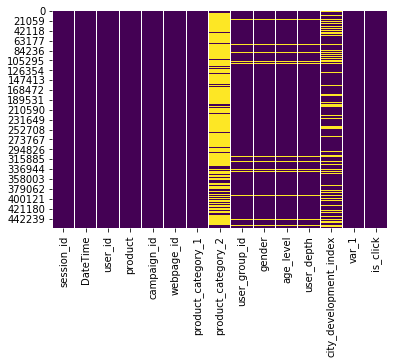

In [4]:
for i in data.columns:
    print('NaN Count for', i, '==>', data[i].isna().sum())
sns.heatmap(data.isnull(), cmap='viridis', cbar=False)

## Conclusions:
- Couple of Feature columns have considerable amount of missing values and need to be imputed.

0    431960
1     31331
Name: is_click, dtype: int64

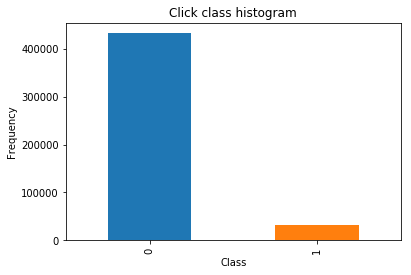

In [5]:
pd.value_counts(data['is_click']).plot.bar()
plt.title('Click class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
data['is_click'].value_counts()

## Conclusions:
-  The dataset is heavily unbalanced with a bias towards Class-0 and need to be treated.

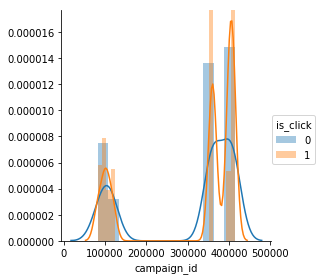

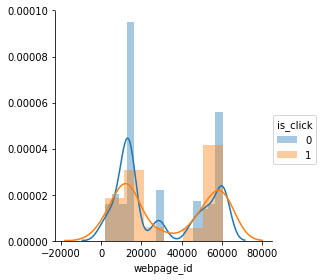

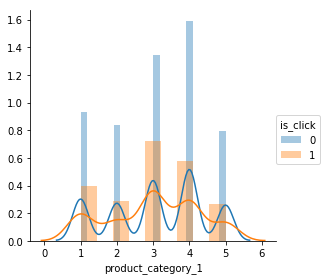

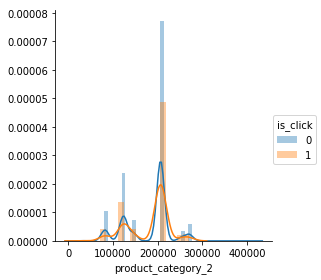

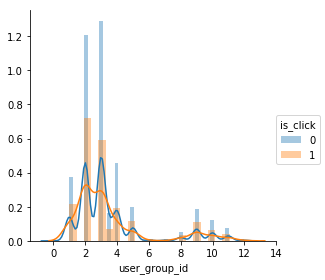

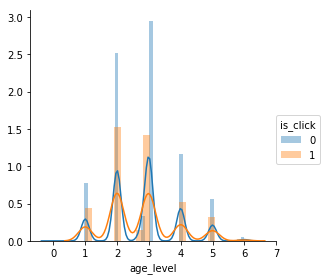

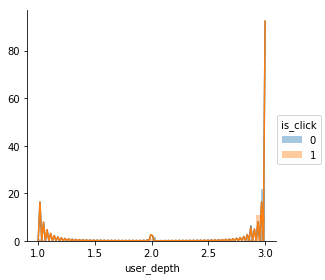

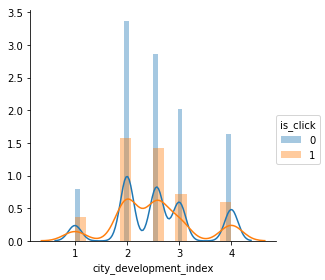

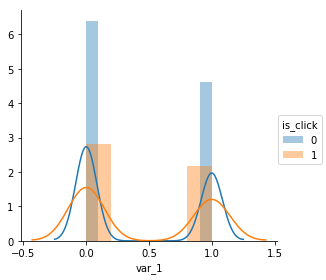

In [9]:
for i in ['campaign_id','webpage_id','product_category_1','product_category_2','user_group_id',\
          'age_level','user_depth','city_development_index','var_1']:
    sns.FacetGrid(data, hue='is_click', size=4) \
        .map(sns.distplot, i) \
        .add_legend()
    plt.show()

In [3]:
def time_bin(tstamp):
    hhmm = int(''.join(tstamp[-5:].split(':')))
    if 0 <= hhmm <= 559:
        return 1
    elif 600 <= hhmm <= 1159:
        return 2
    elif 1200 <= hhmm <= 1759:
        return 3
    elif 1800 <= hhmm <= 2359:
        return 4

In [4]:
%%time
hist['FE_time_bins'] = hist['DateTime'].apply(time_bin)
hist_action = {}
def build_history(row):
    global hist_action
    # key = (row['FE_time_bins'], row['user_id'], row['product'], row['action'])
    key = (row['user_id'], row['product'], row['action'])
    if hist_action.get(key, 0) == 0:
        hist_action[key] = 1
    else:
        hist_action[key] += 1
batch = last_batch = 0
while batch <= hist.shape[0]:
    batch = batch + 1000000
    print("Running Batch Range ===> {}-{}".format(last_batch, batch-1))
    hist[last_batch:batch].apply(build_history, axis=1)
    last_batch = batch
print(len(hist_action))

Running Batch Range ===> 0-999999
44661
Wall time: 1.43 s


In [8]:
hist.head()

,DateTime,user_id,product,action,FE_time_bins
0,2017-05-28 15:44,704,B,view,3
1,2017-05-29 07:08,499679,F,view,2
2,2017-05-29 07:10,499679,G,view,2
3,2017-05-29 07:10,499679,G,view,2
4,2017-05-29 07:10,499679,G,view,2


In [5]:
def pre_process(data):
    
    # Feature engineer Columns with missing values - capture info if the original dataset has a missing value against the
    # current datapoint [1: Missing Value present, 0: Not missing].
    data['FE_time'] = data['DateTime'].apply(time_bin)
    data['FE_pc2'] = data['product_category_2'].apply(lambda x: 1 if math.isnan(x) else 0)
    data['FE_grp'] = data['user_group_id'].apply(lambda x: 1 if math.isnan(x) else 0)
    data['FE_gender'] = data['gender'].apply(lambda x: 1 if x not in ['Male', 'Female'] else 0)
    data['FE_age'] = data['age_level'].apply(lambda x: 1 if math.isnan(x) else 0)
    data['FE_usr_depth'] = data['user_depth'].apply(lambda x: 1 if math.isnan(x) else 0)
    data['FE_cdi'] = data['city_development_index'].apply(lambda x: 1 if math.isnan(x) else 0)

    # Add two features - for 'view' and 'interest' bassed on the history transaction data available.
    # Key used to match --> 'Timestamp bin#', 'User ID', 'Product' and Action taken.
    data['FE_hist_view'] = data.apply(lambda row: hist_action.get((row['user_id'], row['product'], 'view'), 0), axis=1)
    data['FE_hist_interest'] = data.apply(lambda row: hist_action.get((row['user_id'], row['product'], 'interest'), 0), axis=1)
#     data['FE_hist_view'] = data.apply(lambda row: hist_action.get((row['FE_time'], \
#                                                                    row['user_id'], row['product'], 'view'), 0), axis=1)
#     data['FE_hist_interest'] = data.apply(lambda row: hist_action.get((row['FE_time'], \
#                                                                        row['user_id'], row['product'], 'interest'), 0), axis=1)

    # Impute missing values with median values for the Feature column.
    data['product_category_2'].fillna(data['product_category_2'].median(), inplace=True)
    data['user_group_id'].fillna(data['user_group_id'].median(), inplace=True)
    # data['gender'].fillna(data['gender'].median(), inplace=True)
    data['age_level'].fillna(data['age_level'].median(), inplace=True)
    data['user_depth'].fillna(data['user_depth'].median(), inplace=True)
    data['city_development_index'].fillna(data['city_development_index'].median(), inplace=True)

    # One hot encode non-numerical categorical features
    prods_one_hot = pd.get_dummies(data['product'], drop_first=True, prefix='_')
    gender_one_hot = pd.get_dummies(data['gender'], drop_first=True, prefix='_')
    data = pd.concat([data,prods_one_hot,gender_one_hot], axis=1)

    # Drop columns which are not required for further processing.
    data.drop(columns=['session_id', 'user_id', 'product', 'gender', 'DateTime'], inplace=True)
    
    return data

In [6]:
%%time
# Sort data by Timestamp
data.sort_values(by='DateTime', inplace=True)

# Split Data into Train and Test with 70/30 split  ---> Time-based Splitting used
train_val = int(data.shape[0] * 0.70)
train = data[:train_val]
test = data[train_val:]

# Pre-process the data - impute missing values, feature engineer, one-hot encode non-numeric categorical Features
train = pre_process(train)
test = pre_process(test)

# Standardize data
sc = StandardScaler()
X_Train = train.drop(['is_click'], axis=1)
X_Train = sc.fit_transform(X_Train)
y_Train = train['is_click']

# Remove Imbalancedness using SMOTE
print("Class-'1' count in X_Train before Oversampling: {}".format(sum(y_Train==1)))
print("Class-'0' count in X_Train before Oversampling: {}".format(sum(y_Train==0)))
sm = SMOTE(random_state=2)
X_Train, y_Train = sm.fit_sample(X_Train, y_Train.ravel())
print("Class-'1' count in X_Train after Oversampling: {}".format(sum(y_Train==1)))
print("Class-'0' count in X_Train after Oversampling: {}".format(sum(y_Train==0)))

X_Test = test.drop(['is_click'], axis=1)
X_Test = sc.transform(X_Test)
y_Test = test['is_click']

Class-'1' count in X_Train before Oversampling: 483
Class-'0' count in X_Train before Oversampling: 6517
Class-'1' count in X_Train after Oversampling: 6517
Class-'0' count in X_Train after Oversampling: 6517
Wall time: 1.4 s


In [7]:
%%time
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, scoring='roc_auc', param_distributions = random_grid, \
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = 1)

# Fit the random search model
rf_random.fit(X_Train, y_Train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.4s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.5s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.4s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total=   5.6s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total=   5.7s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=600,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.2min finished


Wall time: 5min 42s


In [8]:
pprint(rf_random.best_params_)

best_random = rf_random.best_estimator_
preds = best_random.predict(X_Test)
acc = accuracy_score(y_Test, preds) * 100

print(acc)
print(pd.Series(preds).value_counts())

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 2000}
91.53333333333333
0    2912
1      88
dtype: int64


In [18]:
%%time
rf = RandomForestClassifier(bootstrap=False, max_depth=60, max_features='auto', \
                            min_samples_leaf=2, min_samples_split=2, n_estimators=600)
rf.fit(X_Train, y_Train)

test = pd.read_csv('./test_LNMuIYp/test.csv')
print(test.shape)
sess_ids = test['session_id']

test = pre_process(test)
test = sc.transform(test)
pred = rf.predict(test)

print(pred)
soln = pd.concat([sess_ids, pd.DataFrame(pred)], axis=1)
soln.columns=['session_id', 'is_click']
print(soln.shape)
soln.to_csv('Solution_v2.0.csv', index=False)

(128858, 14)
[0 0 0 ... 1 0 0]
(128858, 2)
Wall time: 34min 21s
